In [7]:
import json
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
#import squarify
from functools import reduce
import os
path = """C:\\Users\\Koushik\\Downloads\\open-data-master\\open-data-master\\data\\my_events\\"""
Xg_req = pd.DataFrame(data=None)
for filename in (os.listdir(path)):
    #print(filename)
    
    with open("%s" % path + filename,encoding="utf8") as data_file:    
        data = json.load(data_file)
        df = pd.DataFrame(data=None)
        
        df = json_normalize(data, sep = "_")
        
        df =  df[(df['type_name'] == "Shot")]
        df = df.loc[:,['location','shot_body_part_id','shot_end_location','shot_one_on_one','shot_technique_id','shot_type_id','under_pressure','shot_outcome_id']]
        #print(df.shape)
    Xg_req = Xg_req.append(df,ignore_index=True,sort=False)
        #df.drop(df.index, inplace=True)
        
print("done")  

done


In [8]:
Xg_req[['shot_X_axis','shot_Y_axis']] = pd.DataFrame(Xg_req.location.values.tolist(), index= Xg_req.location.index) # has the x,y coordinates of shot loc
Xg_req[['shot_end_X_axis','shot_end_Y_axis','shot_end_Z_axis']] = pd.DataFrame(Xg_req.shot_end_location.values.tolist(), index= Xg_req.location.index)
#print(Xg_req.location.head())
#print(Xg_req.shot_end_location.head())
#print(Xg_req.shot_X_axis)

In [9]:
Xg_req[['shot_end_Z_axis']] = pd.DataFrame(Xg_req.shot_end_Z_axis.fillna(0),index= Xg_req.location.index)
Xg_req[['shot_one_on_one']] = pd.DataFrame(Xg_req.shot_one_on_one.fillna(False),index= Xg_req.location.index)
Xg_req[['under_pressure']] = pd.DataFrame(Xg_req.under_pressure.fillna(False),index= Xg_req.location.index)

Xg_req = Xg_req.loc[:,['shot_body_part_id','shot_one_on_one','shot_technique_id','shot_type_id','under_pressure','shot_outcome_id','shot_end_X_axis','shot_end_Y_axis','shot_end_Z_axis','shot_X_axis','shot_Y_axis']]


In [10]:
import math # to calculate distance from shot location to goal post ends
#dist_bc=8
dist_ab = np.zeros(shape=(Xg_req.shape[0]))
dist_ca = np.zeros(shape=(Xg_req.shape[0]))
x = Xg_req.shot_X_axis.values.tolist()
y = Xg_req.shot_Y_axis.values.tolist()
x = np.asarray(x)
y = np.asarray(y)
for i in range(0,x.size):
    dist_ca[i] = math.sqrt((x[i] -120 )**2 + (y[i] - 44)**2) #CA
    dist_ab[i] = math.sqrt((x[i] - 120)**2 + (y[i] - 36)**2)


In [22]:
# to calculate angle for shot loc to post 
angle_A = np.zeros(shape=(Xg_req.shape[0]))
for i in range(0,dist_ab.size):
    angle_A[i] = math.acos(((dist_ca[i]**2) + (dist_ab[i]**2) - 64) / (2 * dist_ca[i] *dist_ab[i])) #inverse_cos((b^2+c^2-a^2)/(2 * c * a))
    angle_A[i] = angle_A[i]*180/math.pi   #to convert angle to degrees from rad


Xg_req[['shot_angle']] = pd.DataFrame(angle_A,index= Xg_req.shot_X_axis.index)    
goal =  Xg_req[(Xg_req['shot_outcome_id'] == 97)] #shot_outcome_id 97 == GOAL
goal = goal.loc[:,['shot_X_axis','shot_Y_axis','shot_end_X_axis','shot_end_Y_axis','shot_end_Z_axis']]
Pred_X = np.zeros(shape=(Xg_req.shape[0])) # value to be predicted
for i in range(0,Pred_X.size):
    if Xg_req.shot_outcome_id[i] == 97:
        Pred_X[i] = 1
    else:
        Pred_X[i] = 0


In [12]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

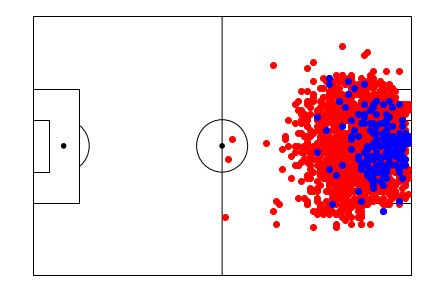

In [13]:
fig=plt.figure() #set up the figures
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.plot(Xg_req.shot_X_axis,Xg_req.shot_Y_axis,'ro')
plt.plot(goal.shot_X_axis,goal.shot_Y_axis,'bo')
plt.axis('off')
plt.show()

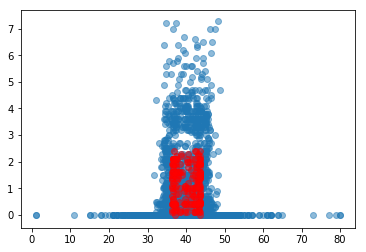

In [29]:
import matplotlib.pyplot as plt



plt.scatter(Xg_req.shot_end_Y_axis,Xg_req.shot_end_Z_axis, alpha=0.5)
plt.scatter(goal.shot_end_Y_axis,goal.shot_end_Z_axis, alpha=0.5,color='red')
plt.show()

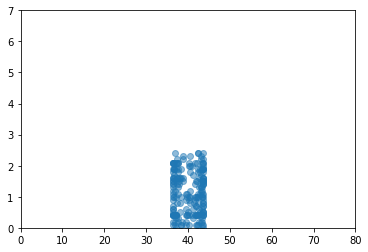

In [25]:
import matplotlib.pyplot as plt

plt.ylim(0, 7)
plt.xlim(0, 80)

plt.scatter(goal.shot_end_Y_axis,goal.shot_end_Z_axis, alpha=0.5)
plt.show()

In [8]:
Xg_req.columns
X = Xg_req[['shot_body_part_id', 'shot_one_on_one', 'shot_technique_id','shot_type_id', 'under_pressure','shot_end_X_axis',
       'shot_end_Y_axis', 'shot_end_Z_axis', 'shot_X_axis', 'shot_Y_axis','shot_angle']]
Y = Pred_X

In [21]:
#LogisticRegression model for predicting Xg
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
log_r = LogisticRegression()

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2 , random_state = 52)

log_r.fit(X_train,y_train)
print("Log regression test accuracy {:.3f}".format(log_r.score(X_train,y_train)))

Log regression test accuracy 0.900


C:\Users\Koushik\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [107]:
prediction = log_r.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,prediction)
print(confusion_matrix)


[[325   5]
 [ 43   4]]


In [109]:
from sklearn.metrics import accuracy_score
import xgboost as xgb  #xgboost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
#print(model)
prediction = model.predict(X_test)
#prediction = log_r.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,prediction)
print(confusion_matrix)

[[325   5]
 [ 14  33]]


In [ ]:
#!pip install --upgrade tensorflow
!pip uninstall tensorflow
print("done")

In [20]:

#X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2 , random_state = 52)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense #'shot_body_part_id', 'shot_one_on_one', 'shot_technique_id','shot_type_id', 'under_pressure','shot_end_X_axis',
       #'shot_end_Y_axis', 'shot_end_Z_axis', 'shot_X_axis', 'shot_Y_axis','shot_angle'
model = Sequential()
model.add(Dense(3,input_dim = 11,activation = 'relu' ))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'mean_absolute_error',optimizer = 'adam',metrics = ['binary_accuracy'])
model.fit(X_train,y_train,epoch = 100,verbose = 2)

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\Koushik\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "C:\Users\Koushik\Anaconda3\lib\imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Koushik\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Koushik\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Koushik\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.